In [1]:
pip install ipykernel

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
bancarrota=pd.read_csv("train_data.csv")
bancarrota_test=pd.read_csv("test_data.csv")
bancarrota.head()

,ID,Bankruptcy,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,...,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
0,1,0,0.087661,1.900349e-04,0.131094,0.583345,0.000000,0.815892,0.395719,0.089276,...,0.223720,0.801737,0,0.839112,0.036551,0.591350,0.007401,0.913175,0.489822,0.138714
1,2,0,0.021892,5.371576e-04,0.086167,0.695478,0.209649,0.768636,0.163505,0.000000,...,0.324763,0.791203,0,0.908450,0.126752,0.766066,0.020514,0.849241,0.550247,0.704211
2,3,0,0.102249,2.178329e-04,0.157755,0.766934,0.272061,0.643316,0.181571,0.010180,...,0.360892,0.803126,0,0.865943,0.018152,0.687211,0.004363,0.865814,0.447168,0.398086
3,4,0,0.029972,4.915756e+10,0.249279,0.611580,0.288357,0.752782,0.409196,0.018603,...,0.152445,0.824732,0,0.806254,0.051284,0.715973,0.014162,0.843357,0.485163,0.617386
4,6,0,0.021164,1.206001e-04,0.239817,0.614250,0.000000,0.559498,0.286989,0.148687,...,0.217282,0.787010,0,0.769843,0.012872,0.704043,0.003050,0.884905,0.422001,0.187121


PREPROCESAMIENTO

In [6]:
# Ver cuántos valores nulos hay por columna
bancarrota.isnull().sum().sort_values(ascending=False)


ID                                         0
Bankruptcy                                 0
Realized.Sales.Gross.Profit.Growth.Rate    0
Operating.Expense.Rate                     0
Operating.Profit.Per.Share..Yuan...        0
                                          ..
Operating.Gross.Margin                     0
Contingent.liabilities.Net.worth           0
Operating.Profit.Growth.Rate               0
Cash.Flow.to.Liability                     0
Quick.Assets.Total.Assets                  0
Length: 65, dtype: int64

In [7]:

# Variables más positivamente correlacionadas
vars_positivas = [
    'Debt.ratio..',                             # Razón de endeudamiento
    'Current.Liability.to.Current.Assets',      # Pasivo corriente / activo corriente
    'Current.Liability.to.Assets',              # Pasivo corriente / activos totales
    'Liability.Assets.Flag',                    # Indicador de pasivo / activos
    'Revenue.per.person'                        # Ingresos por persona
]
# Variables más negativamente correlacionadas
vars_negativas = [
    'Retained.Earnings.to.Total.Assets',        # Utilidades retenidas / activos totales
    'Working.Capital.to.Total.Assets',          # Capital de trabajo / activos totales
    'ROA.B..before.interest.and.depreciation.after.tax',  # ROA antes de intereses e impuestos
    'Tax.rate..A.',                             # Tasa impositiva
    'Quick.Assets.Total.Assets'                # Activo líquido / activos totales
]


In [8]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
variables_seleccionadas = vars_positivas + vars_negativas

# Separar variables predictoras y objetivo en entrenamiento
X = bancarrota[variables_seleccionadas]
y = bancarrota['Bankruptcy']

#Dividir en entrenamiento y validacion
X_entrenamiento,X_validacion, y_entrenamiento, y_validacion= train_test_split( X, y, test_size=0.2, random_state=42,stratify=y)

# Estandarizar
scaler = StandardScaler()
X_entrenamiento_scaled = scaler.fit_transform(X_entrenamiento)
X_validacion_scaled=scaler.transform(X_validacion)

# Preparar también el test set para predicciones de Kaggle
X_test = bancarrota_test[variables_seleccionadas]
X_test_scaled = scaler.transform(X_test)

#Aplicar oversampling
ros=RandomOverSampler (random_state=42)
X_resampled_k,y_resampled_k=ros.fit_resample(X_entrenamiento_scaled,y_entrenamiento)


PRIMER MODELO 

In [22]:
#Multilayer Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import pandas as pd

# 1. Definir el modelo
modelo_nn = Sequential()
modelo_nn.add(Dense(64, activation='relu', input_shape=(X_resampled_k.shape[1],)))
modelo_nn.add(Dropout(0.3))
modelo_nn.add(Dense(32, activation='relu'))
modelo_nn.add(Dropout(0.3))
modelo_nn.add(Dense(1, activation='sigmoid'))  # Salida para clasificación binaria

# 2. Compilar
modelo_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc')]
)

# 3. Entrenar el modelo
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

historial = modelo_nn.fit(
    X_resampled_k,
    y_resampled_k,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 4. Predicciones sobre test
probabilidades = modelo_nn.predict(X_test_scaled).flatten()

# 5. Crear archivo de envío
submission = pd.DataFrame({
    'ID': bancarrota_test['ID'],
    'Bankruptcy': probabilidades
})

submission.to_csv('submission_red_neuronal.csv', index=False)
print("Archivo 'submission_red_neuronal.csv' creado.")


Epoch 1/100


c:\Users\Yoselin\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc: 0.6829 - loss: 0.6375 - val_auc: 0.0000e+00 - val_loss: 0.4672
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8770 - loss: 0.4503 - val_auc: 0.0000e+00 - val_loss: 0.4269
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9072 - loss: 0.3824 - val_auc: 0.0000e+00 - val_loss: 0.4110
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9207 - loss: 0.3459 - val_auc: 0.0000e+00 - val_loss: 0.4399
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9215 - loss: 0.3441 - val_auc: 0.0000e+00 - val_loss: 0.3722
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9278 - loss: 0.3297 - val_auc: 0.0000e+00 - val_loss: 0.3931
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9330 - loss: 0.3175 - val_auc: 0.0000e+00 - val_loss: 0.3509
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9434 - loss: 0.2941 - val_auc: 0.0000e+00 - val_loss: 0.2993
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

In [23]:
test_loss, test_acc = modelo_nn.evaluate(X_validacion_scaled, y_validacion)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8559 - loss: 0.2546 


In [36]:
# Obtener las probabilidades predichas sobre el set de validación
probabilidades_validacion_nn = modelo_nn.predict(X_validacion_scaled).flatten()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [37]:
from sklearn.metrics import roc_auc_score

# Calcular el AUC
auc_score_nn = roc_auc_score(y_validacion, probabilidades_validacion_nn)
print(f"AUC en Validación (Modelo de Red Neuronal): {auc_score_nn:.4f}")


AUC en Validación (Modelo de Red Neuronal): 0.8486


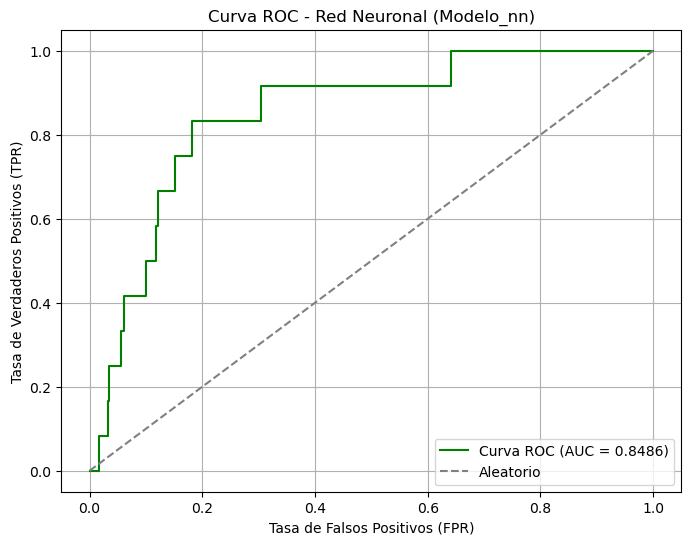

In [38]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calcular la curva ROC
fpr_nn, tpr_nn, umbrales_nn = roc_curve(y_validacion, probabilidades_validacion_nn)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr_nn, tpr_nn, label=f'Curva ROC (AUC = {auc_score_nn:.4f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Red Neuronal (Modelo_nn)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


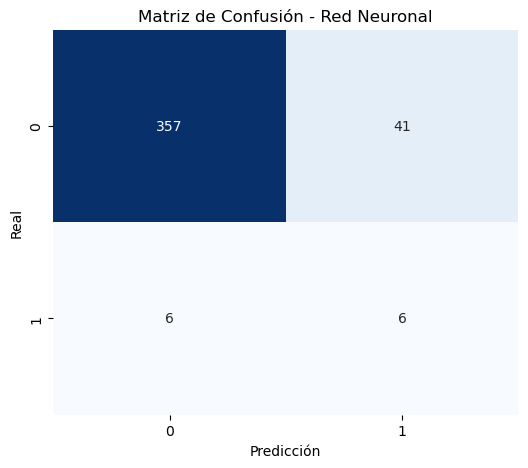

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Convertir probabilidades en clases predichas (umbral de 0.5)
clases_predichas_nn = (probabilidades_validacion_nn >= 0.5).astype(int)

# Calcular matriz de confusión
matriz_confusion_nn = confusion_matrix(y_validacion, clases_predichas_nn)

# Graficar la matriz de confusión como mapa de calor
plt.figure(figsize=(6,5))
sns.heatmap(matriz_confusion_nn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Red Neuronal')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


SEGUNDO MODELO----No se usa en el informe

In [10]:
#MLP Classifier
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_entrenamiento_scaled, y_entrenamiento)

# Entrenar el modelo MLP con los datos balanceados
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), 
                    activation='relu',
                    solver='adam',
                    max_iter=300,
                    random_state=42)

mlp.fit(X_resampled, y_resampled)


c:\Users\Yoselin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=300, random_state=42)

In [12]:
from sklearn.metrics import roc_auc_score, classification_report

# Predicción de probabilidades sobre el set de entrenamiento
y_train_pred_proba = mlp.predict_proba(X_entrenamiento_scaled)[:, 1]

# Calcular AUC
auc_entrenamiento = roc_auc_score(y_entrenamiento, y_train_pred_proba)
print(f"AUC en el set de entrenamiento: {auc_entrenamiento:.4f}")

# Clasificación básica (opcional, para revisar precisión, recall, etc.)
y_train_pred = mlp.predict(X_entrenamiento_scaled)
print(classification_report(y_entrenamiento, y_train_pred))


AUC en el set de entrenamiento: 0.9993
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1590
           1       0.54      1.00      0.70        50

    accuracy                           0.97      1640
   macro avg       0.77      0.99      0.85      1640
weighted avg       0.99      0.97      0.98      1640



In [16]:
# 1. Predecir probabilidades de clase 1
y_test_proba = mlp.predict_proba(X_test_scaled)[:, 1]

# 2. Obtener la columna ID desde el test original
IDs = bancarrota_test['ID']  # asegúrate de que se llame exactamente así

# 3. Crear el DataFrame de envío
envio = pd.DataFrame({
    'ID': IDs,
    'Bankruptcy': y_test_proba
})

# 4. Guardar como CSV
envio.to_csv('submission.csv', index=False)

print("✅ Archivo 'submission.csv' generado con éxito.")


✅ Archivo 'submission.csv' generado con éxito.


In [32]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Obtener las probabilidades predichas (probabilidad de clase 1)
probabilidades_validacion_mlp = mlp.predict_proba(X_validacion_scaled)[:, 1]


In [ ]:
# ---------------------------------------------------------------------------
# CÉLULA 14: GERAR ARQUIVO DE SUBMISSÃO PARA O TESTE 13
# ---------------------------------------------------------------------------
# Usa o modelo 'modelo_teste_13_nb' treinado na célula anterior

print("--- Realizando predições no conjunto de teste (X_test_scaled) ---")
# Garanta que modelo_teste_13_nb e X_test_scaled existem
probabilidades_teste_13 = modelo_teste_13_nb.predict(X_test_scaled).flatten()

print("--- Criando DataFrame para submissão ---")
# Garanta que bancarrota_test com a coluna 'ID' existe
submission_teste_13 = pd.DataFrame({
    'ID': bancarrota_test['ID'],
    'Bankruptcy': probabilidades_teste_13
})

submission_filename_13 = 'submission_teste_13_AUC_0.8867.csv'
submission_teste_13.to_csv(submission_filename_13, index=False)
print(f"Arquivo '{submission_filename_13}' criado com sucesso.")
print("-" * 50)

In [33]:
# Calcular el AUC
auc_score_mlp = roc_auc_score(y_validacion, probabilidades_validacion_mlp)
print(f"AUC en validación (MLPClassifier): {auc_score_mlp:.4f}")


AUC en validación (MLPClassifier): 0.8501


In [34]:
# Convertir probabilidades a clases usando umbral 0.5
predicciones_clases_mlp = (probabilidades_validacion_mlp >= 0.5).astype(int)

# Matriz de confusión
matriz_confusion_mlp = confusion_matrix(y_validacion, predicciones_clases_mlp)
print("Matriz de confusión (MLPClassifier):")
print(matriz_confusion_mlp)

# (Opcional) Reporte de clasificación
print("\nReporte de clasificación (MLPClassifier):")
print(classification_report(y_validacion, predicciones_clases_mlp))


Matriz de confusión (MLPClassifier):
[[376  22]
 [  7   5]]

Reporte de clasificación (MLPClassifier):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       398
           1       0.19      0.42      0.26        12

    accuracy                           0.93       410
   macro avg       0.58      0.68      0.61       410
weighted avg       0.96      0.93      0.94       410



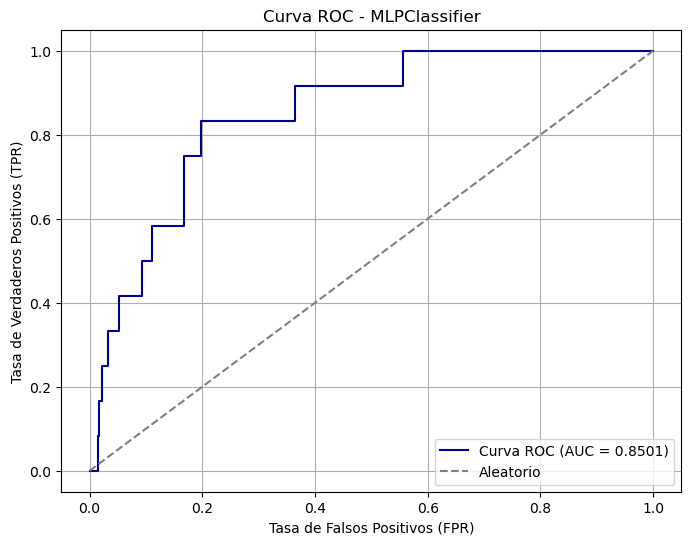

In [35]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calcular la curva ROC
fpr_mlp, tpr_mlp, umbrales_mlp = roc_curve(y_validacion, probabilidades_validacion_mlp)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr_mlp, tpr_mlp, label=f'Curva ROC (AUC = {auc_score_mlp:.4f})', color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - MLPClassifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


MODELO 3

In [ ]:
# ---------------------------------------------------------------------------
# RE-EXECUÇÃO TESTE 7 (com variáveis _teste_7 para compatibilidade)
# Config: 128/64, D=0.2, L2=0.001, LR=0.0005 + Scheduler
# ---------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# Certifique-se que X_resampled_k, y_resampled_k, X_validacion_scaled, y_validacion
# estão carregados no seu ambiente.

# --- Parâmetros do Teste 7 ---
neurons_layer1_teste_7 = 128
dropout_rate1_teste_7 = 0.2
neurons_layer2_teste_7 = 64
dropout_rate2_teste_7 = 0.2
l2_rate_teste_7 = 0.001
initial_learning_rate_teste_7 = 0.0005
epochs_teste_7 = 150
batch_size_teste_7 = 32
es_patience_teste_7 = 15
lr_patience_teste_7 = 5
lr_factor_teste_7 = 0.2

print(f"--- Re-executando Teste 7 (com nomes _teste_7): {neurons_layer1_teste_7}/{neurons_layer2_teste_7} N, D={dropout_rate1_teste_7}/{dropout_rate2_teste_7}, L2={l2_rate_teste_7}, LR_init={initial_learning_rate_teste_7} ---")

# --- 1. Definir o Modelo ---
# Usando um nome único para o objeto do modelo para evitar conflitos se o nome 'modelo_teste_7_nb' ainda existir
modelo_teste_7_rerun_compat = Sequential(name="Modelo_Teste_7_Rerun_Compat")
modelo_teste_7_rerun_compat.add(Input(shape=(X_resampled_k.shape[1],), name="Input_Layer_teste_7"))
modelo_teste_7_rerun_compat.add(Dense(neurons_layer1_teste_7, activation='relu', kernel_regularizer=l2(l2_rate_teste_7), name="Dense_1_teste_7"))
modelo_teste_7_rerun_compat.add(Dropout(dropout_rate1_teste_7, name="Dropout_1_teste_7"))
modelo_teste_7_rerun_compat.add(Dense(neurons_layer2_teste_7, activation='relu', kernel_regularizer=l2(l2_rate_teste_7), name="Dense_2_teste_7"))
modelo_teste_7_rerun_compat.add(Dropout(dropout_rate2_teste_7, name="Dropout_2_teste_7"))
modelo_teste_7_rerun_compat.add(Dense(1, activation='sigmoid', name="Output_Layer_teste_7"))

# --- 2. Compilar ---
optimizer_teste_7 = Adam(learning_rate=initial_learning_rate_teste_7)
modelo_teste_7_rerun_compat.compile(optimizer=optimizer_teste_7, loss='binary_crossentropy', metrics=[AUC(name='auc')])
print("\nModelo Teste 7 (Rerun) compilado com Adam (LR inicial={}).".format(initial_learning_rate_teste_7))

# --- 3. Callbacks ---
early_stop_teste_7 = EarlyStopping(monitor='val_auc', mode='max', patience=es_patience_teste_7, restore_best_weights=True, verbose=1)
reduce_lr_teste_7 = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=lr_factor_teste_7, patience=lr_patience_teste_7, min_lr=0.000001, verbose=1)
print("Callbacks Teste 7 (Rerun) configurados: EarlyStopping(patience={}), ReduceLROnPlateau(patience={})".format(es_patience_teste_7, lr_patience_teste_7))

# --- 4. Treinar ---
print("\n--- Iniciando Treinamento Teste 7 (Rerun) ---")
history_teste_7 = modelo_teste_7_rerun_compat.fit(
    X_resampled_k, y_resampled_k,                        # Treino Oversampled
    validation_data=(X_validacion_scaled, y_validacion),# Validação Original
    epochs=epochs_teste_7,
    batch_size=batch_size_teste_7,
    callbacks=[early_stop_teste_7, reduce_lr_teste_7],
    verbose=0  # Mude para 1 se quiser ver o progresso detalhado das épocas
)
print("-" * 50)
print("--- Treinamento Teste 7 (Rerun) Concluído ---")
print("-" * 50)

# --- 5. Avaliar e Salvar Métricas ---
print("--- Avaliando Teste 7 (Rerun) no conjunto de validação ---")
probabilidades_validacion_teste_7 = modelo_teste_7_rerun_compat.predict(X_validacion_scaled).flatten()

# Salvar com os nomes esperados pela célula de plotagem do Teste 13
auc_score_teste_7 = roc_auc_score(y_validacion, probabilidades_validacion_teste_7)
fpr_teste_7, tpr_teste_7, _ = roc_curve(y_validacion, probabilidades_validacion_teste_7)

if 'val_auc' in history_teste_7.history and len(history_teste_7.history['val_auc']) > 0:
    best_epoch_teste_7 = np.argmax(history_teste_7.history['val_auc'])
    best_val_auc_teste_7 = history_teste_7.history['val_auc'][best_epoch_teste_7]
    print(f"Melhor AUC na Validação (histórico Teste 7): {best_val_auc_teste_7:.4f} (Época: {best_epoch_teste_7 + 1})")
else:
    # Se não houver histórico, usamos o AUC final calculado
    best_val_auc_teste_7 = auc_score_teste_7
    print("Não foi possível obter o melhor AUC do histórico do Teste 7.")

print(f"AUC na Validação (final Teste 7, após restore_best_weights): {auc_score_teste_7:.4f}")
print("Variáveis fpr_teste_7, tpr_teste_7, e auc_score_teste_7 agora contêm os resultados corretos do Teste 7.")
print("-" * 50)

# Agora você pode usar fpr_teste_7, tpr_teste_7, auc_score_teste_7 na célula de plotagem comparativa do Teste 13.

--- Iniciando Teste 13: 128/64 N, D=0.2/0.2, L2=0.001, LR_init=0.0002, Patience ES/LR: 20/10 ---

Modelo compilado com Adam (LR inicial=0.0002).
Callbacks configurados: EarlyStopping(patience=20), ReduceLROnPlateau(patience=10)

--- Iniciando Treinamento ---
Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6682 - loss: 0.7565 - val_auc: 0.8871 - val_loss: 0.7514 - learning_rate: 2.0000e-04
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8948 - loss: 0.5936 - val_auc: 0.8745 - val_loss: 0.6302 - learning_rate: 2.0000e-04
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9139 - loss: 0.5086 - val_auc: 0.8689 - val_loss: 0.5248 - learning_rate: 2.0000e-04
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9164 - loss: 0.4790 - val_auc: 0.8644 - val_loss: 0.5211 - learning_rate: 2.0000e-04
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9304 - loss: 0.4429 - val_auc: 0.8656 - val_loss: 0.5022 - learning_rate: 2.0000e-04
Epoch 

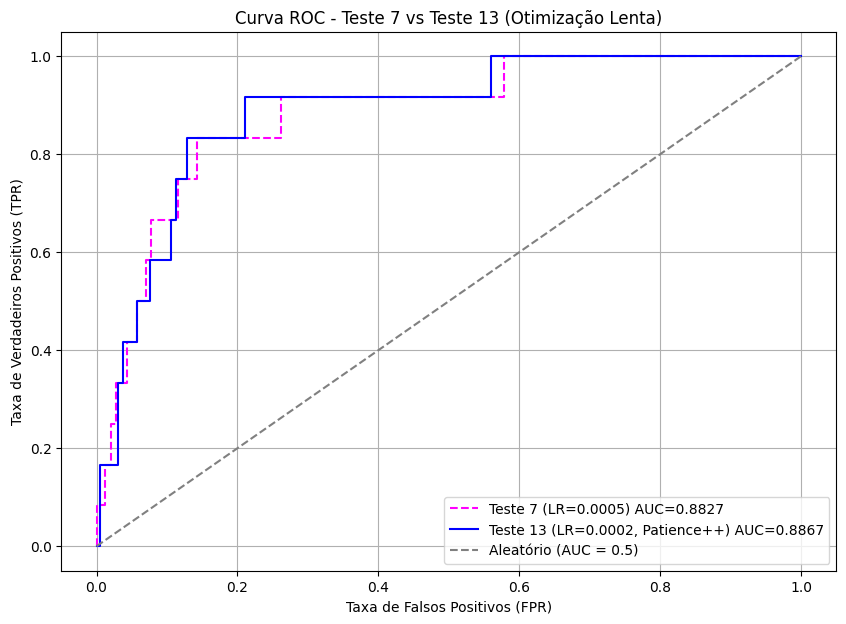

--------------------------------------------------


In [ ]:
# # ---------------------------------------------------------------------------
# # TESTE 13: Otimização Mais Lenta e Gradual
# # ---------------------------------------------------------------------------
# # Objetivo: Tentar quebrar o platô de ~0.88 com NN, focando na otimização.
# # Hipótese: LR inicial menor e mais paciência no scheduler podem estabilizar
# #           o treino e permitir alcançar um pico melhor.

# # --- Imports Necessários ---
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Input
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.metrics import AUC
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam
# import numpy as np
# from sklearn.metrics import roc_auc_score, roc_curve
# import matplotlib.pyplot as plt
# import pandas as pd
# # Certifique-se que as bibliotecas de pré-processamento e os dados estão carregados
# # (incluindo X_resampled_k, y_resampled_k, X_validacion_scaled, y_validacion)

# # --- Parâmetros do Teste 13 ---
# neurons_layer1_13 = 128
# dropout_rate1_13 = 0.2
# neurons_layer2_13 = 64
# dropout_rate2_13 = 0.2
# l2_rate_13 = 0.001
# initial_learning_rate_13 = 0.0002  # <<< LR inicial BEM baixo
# epochs_13 = 150                    # Manter limite alto
# batch_size_13 = 32
# es_patience_13 = 20                # <<< Aumentar paciência ES
# lr_patience_13 = 10                # <<< Aumentar paciência ReduceLR
# lr_factor_13 = 0.2                 # Manter fator de redução
# TARGET_AUC = 0.91 # Ou 0.92

# print(f"--- Iniciando Teste 13: {neurons_layer1_13}/{neurons_layer2_13} N, D={dropout_rate1_13}/{dropout_rate2_13}, L2={l2_rate_13}, LR_init={initial_learning_rate_13}, Patience ES/LR: {es_patience_13}/{lr_patience_13} ---")

# # --- Garantir Dados Oversampled ---
# # Assegure que X_resampled_k, y_resampled_k, X_validacion_scaled, y_validacion existem

# # --- 1. Definir o Modelo ---
# modelo_teste_13_nb = Sequential(name="Modelo_Teste_13_Notebook")
# modelo_teste_13_nb.add(Input(shape=(X_resampled_k.shape[1],), name="Input_Layer"))
# modelo_teste_13_nb.add(Dense(neurons_layer1_13, activation='relu', kernel_regularizer=l2(l2_rate_13), name="Dense_1"))
# modelo_teste_13_nb.add(Dropout(dropout_rate1_13, name="Dropout_1"))
# modelo_teste_13_nb.add(Dense(neurons_layer2_13, activation='relu', kernel_regularizer=l2(l2_rate_13), name="Dense_2"))
# modelo_teste_13_nb.add(Dropout(dropout_rate2_13, name="Dropout_2"))
# modelo_teste_13_nb.add(Dense(1, activation='sigmoid', name="Output_Layer"))
# # modelo_teste_13_nb.summary() # Opcional

# # --- 2. Compilar ---
# optimizer_custom_13 = Adam(learning_rate=initial_learning_rate_13)
# modelo_teste_13_nb.compile(optimizer=optimizer_custom_13, loss='binary_crossentropy', metrics=[AUC(name='auc')])
# print("\nModelo compilado com Adam (LR inicial={}).".format(initial_learning_rate_13))

# # --- 3. Callbacks ---
# early_stop_13 = EarlyStopping(monitor='val_auc', mode='max', patience=es_patience_13, restore_best_weights=True, verbose=1)
# reduce_lr_13 = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=lr_factor_13, patience=lr_patience_13, min_lr=0.000001, verbose=1) # min_lr ajustado
# print("Callbacks configurados: EarlyStopping(patience={}), ReduceLROnPlateau(patience={})".format(es_patience_13, lr_patience_13))

# # --- 4. Treinar ---
# print("\n--- Iniciando Treinamento ---")
# historial_teste_13 = modelo_teste_13_nb.fit(
#     X_resampled_k, y_resampled_k,                        # Treino Oversampled
#     validation_data=(X_validacion_scaled, y_validacion),# Validação Original
#     epochs=epochs_13,
#     batch_size=batch_size_13,
#     callbacks=[early_stop_13, reduce_lr_13],
#     verbose=1
# )
# print("-" * 50)
# print("--- Treinamento Concluído ---")
# print("-" * 50)

# # --- 5. Avaliar ---
# print("--- Avaliando o modelo no conjunto de validação ---")
# probabilidades_validacion_13 = modelo_teste_13_nb.predict(X_validacion_scaled).flatten()
# auc_score_13 = roc_auc_score(y_validacion, probabilidades_validacion_13)

# if 'val_auc' in historial_teste_13.history and len(historial_teste_13.history['val_auc']) > 0:
#     best_epoch_13 = np.argmax(historial_teste_13.history['val_auc'])
#     best_val_auc_13 = historial_teste_13.history['val_auc'][best_epoch_13]
#     print(f"Melhor AUC na Validação (histórico): {best_val_auc_13:.4f} (Época: {best_epoch_13 + 1})")
# else:
#     best_val_auc_13 = auc_score_13
#     print("Não foi possível obter o melhor AUC do histórico.")

# print(f"AUC na Validação (final, após restore_best_weights): {auc_score_13:.4f}")

# # Comparar com o objetivo
# if auc_score_13 >= TARGET_AUC:
#     print(f">>> Meta de AUC (>= {TARGET_AUC}) ATINGIDA! <<<")
# else:
#     print(f">>> Meta de AUC (>= {TARGET_AUC}) NÃO ATINGIDA. Diferença: {TARGET_AUC - auc_score_13:.4f} <<<")
# print("-" * 50)

# # --- 6. Plotar ROC ---
# print("--- Gerando a curva ROC ---")
# fpr_13, tpr_13, _ = roc_curve(y_validacion, probabilidades_validacion_13)

# plt.figure(figsize=(10, 7))
# # Plotar Teste 7 (melhor anterior) e Teste 13
# plt.plot(fpr_teste_7, tpr_teste_7, label=f'Teste 7 (LR=0.0005) AUC={auc_score_teste_7:.4f}', color='magenta', linestyle='--')
# plt.plot(fpr_13, tpr_13, label=f'Teste 13 (LR=0.0002, Patience++) AUC={auc_score_13:.4f}', color='blue') # Teste 13
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório (AUC = 0.5)')
# plt.title(f'Curva ROC - Teste 7 vs Teste 13 (Otimização Lenta)')
# plt.xlabel('Taxa de Falsos Positivos (FPR)')
# plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()
# print("-" * 50)

# ---------------------------------------------------------------------------
# PRUEBA 13: Optimización Más Lenta y Gradual
# ---------------------------------------------------------------------------
# Objetivo: Intentar romper la meseta de ~0.88 con NN, enfocándose en la optimización.
# Hipótesis: LR inicial menor y más paciencia en el scheduler pueden estabilizar
#            el entrenamiento y permitir alcanzar un pico mejor.

# --- Importaciones Necesarias ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
# Asegúrate de que las bibliotecas de preprocesamiento y los datos estén cargados
# (incluyendo X_resampled_k, y_resampled_k, X_validacion_scaled, y_validacion)

# --- Parámetros de la Prueba 13 ---
neurons_layer1_13 = 128
dropout_rate1_13 = 0.2
neurons_layer2_13 = 64
dropout_rate2_13 = 0.2
l2_rate_13 = 0.001
initial_learning_rate_13 = 0.0002  # <<< LR inicial MUY bajo
epochs_13 = 150                    # Mantener límite alto
batch_size_13 = 32
es_patience_13 = 20                # <<< Aumentar paciencia ES
lr_patience_13 = 10                # <<< Aumentar paciencia ReduceLR
lr_factor_13 = 0.2                 # Mantener factor de reducción
TARGET_AUC = 0.91 # O 0.92 # Meta de AUC

print(f"--- Iniciando Prueba 13: {neurons_layer1_13}/{neurons_layer2_13} N, D={dropout_rate1_13}/{dropout_rate2_13}, L2={l2_rate_13}, LR_init={initial_learning_rate_13}, Patience ES/LR: {es_patience_13}/{lr_patience_13} ---")

# --- Asegurar Datos Sobremuestreados ---
# Asegúrate de que X_resampled_k, y_resampled_k, X_validacion_scaled, y_validacion existen

# --- 1. Definir el Modelo ---
modelo_teste_13_nb = Sequential(name="Modelo_Prueba_13_Notebook")
modelo_teste_13_nb.add(Input(shape=(X_resampled_k.shape[1],), name="Input_Layer"))
modelo_teste_13_nb.add(Dense(neurons_layer1_13, activation='relu', kernel_regularizer=l2(l2_rate_13), name="Dense_1"))
modelo_teste_13_nb.add(Dropout(dropout_rate1_13, name="Dropout_1"))
modelo_teste_13_nb.add(Dense(neurons_layer2_13, activation='relu', kernel_regularizer=l2(l2_rate_13), name="Dense_2"))
modelo_teste_13_nb.add(Dropout(dropout_rate2_13, name="Dropout_2"))
modelo_teste_13_nb.add(Dense(1, activation='sigmoid', name="Output_Layer"))
# modelo_teste_13_nb.summary() # Opcional

# --- 2. Compilar ---
optimizer_custom_13 = Adam(learning_rate=initial_learning_rate_13)
modelo_teste_13_nb.compile(optimizer=optimizer_custom_13, loss='binary_crossentropy', metrics=[AUC(name='auc')])
print(f"\nModelo compilado con Adam (LR inicial={initial_learning_rate_13}).")

# --- 3. Callbacks ---
early_stop_13 = EarlyStopping(monitor='val_auc', mode='max', patience=es_patience_13, restore_best_weights=True, verbose=1)
reduce_lr_13 = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=lr_factor_13, patience=lr_patience_13, min_lr=0.000001, verbose=1) # min_lr ajustado
print(f"Callbacks configurados: EarlyStopping(patience={es_patience_13}), ReduceLROnPlateau(patience={lr_patience_13})")

# --- 4. Entrenar ---
print("\n--- Iniciando Entrenamiento ---")
historial_teste_13 = modelo_teste_13_nb.fit(
    X_resampled_k, y_resampled_k,                        # Entrenamiento Sobremuestreado
    validation_data=(X_validacion_scaled, y_validacion),# Validación Original
    epochs=epochs_13,
    batch_size=batch_size_13,
    callbacks=[early_stop_13, reduce_lr_13],
    verbose=1
)
print("-" * 50)
print("--- Entrenamiento Concluido ---")
print("-" * 50)

# --- 5. Evaluar ---
print("--- Evaluando el modelo en el conjunto de validación ---")
probabilidades_validacion_13 = modelo_teste_13_nb.predict(X_validacion_scaled).flatten()
auc_score_13 = roc_auc_score(y_validacion, probabilidades_validacion_13)

if 'val_auc' in historial_teste_13.history and len(historial_teste_13.history['val_auc']) > 0:
    best_epoch_13 = np.argmax(historial_teste_13.history['val_auc'])
    best_val_auc_13 = historial_teste_13.history['val_auc'][best_epoch_13]
    print(f"Mejor AUC en Validación (historial): {best_val_auc_13:.4f} (Época: {best_epoch_13 + 1})")
else:
    best_val_auc_13 = auc_score_13
    print("No fue posible obtener el mejor AUC del historial.")

print(f"AUC en Validación (final, después de restore_best_weights): {auc_score_13:.4f}")

# Comparar con el objetivo
if auc_score_13 >= TARGET_AUC:
    print(f">>> ¡Meta de AUC (>= {TARGET_AUC}) ALCANZADA! <<<")
else:
    print(f">>> Meta de AUC (>= {TARGET_AUC}) NO ALCANZADA. Diferencia: {TARGET_AUC - auc_score_13:.4f} <<<")
print("-" * 50)

# --- 6. Graficar ROC ---
print("--- Generando la curva ROC ---")
fpr_13, tpr_13, _ = roc_curve(y_validacion, probabilidades_validacion_13)

plt.figure(figsize=(10, 7))
# Graficar Prueba 7 (mejor anterior) y Prueba 13
# Asegúrate de que fpr_teste_7, tpr_teste_7, auc_score_teste_7 existen
plt.plot(fpr_teste_7, tpr_teste_7, label=f'Prueba 7 (LR=0.0005) AUC={auc_score_teste_7:.4f}', color='magenta', linestyle='--')
plt.plot(fpr_13, tpr_13, label=f'Prueba 13 (LR=0.0002, Patience++) AUC={auc_score_13:.4f}', color='blue') # Prueba 13
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio (AUC = 0.5)')
plt.title(f'Curva ROC - Prueba 7 vs Prueba 13 (Optimización Lenta)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("-" * 50)

In [ ]:
# Utiliza el modelo 'modelo_teste_13_nb' entrenado en la celda anterior
print("--- Realizando predicciones en el conjunto de prueba (X_test_scaled) ---")
# Asegúrate de que modelo_teste_13_nb y X_test_scaled existen
probabilidades_teste_13 = modelo_teste_13_nb.predict(X_test_scaled).flatten()

print("--- Creando DataFrame para el envío ---")
# Asegúrate de que bancarrota_test con la columna 'ID' existe
submission_teste_13 = pd.DataFrame({
    'ID': bancarrota_test['ID'],
    'Bankruptcy': probabilidades_teste_13
})

# Define el nombre del archivo de envío (hardcoded en este caso)
submission_filename_13 = 'submission_teste_13_AUC_0.8867.csv'
# Guarda el DataFrame en un archivo CSV
submission_teste_13.to_csv(submission_filename_13, index=False)
# Imprime mensaje de confirmación
print(f"Archivo '{submission_filename_13}' creado con éxito.")
print("-" * 50)

--- Realizando predições no conjunto de teste (X_test_scaled) ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
--- Criando DataFrame para submissão ---
Arquivo 'submission_teste_13_AUC_0.8867.csv' criado com sucesso.
--------------------------------------------------
